In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

import os
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models 
import time

In [18]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cuda')

In [19]:
# Linking the directory folder.
train_data = './Training'
test_data = './Training'

classes = os.listdir(train_data)
print("There is", len(classes), "which is:", classes)

There is 4 which is: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [20]:
train_transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

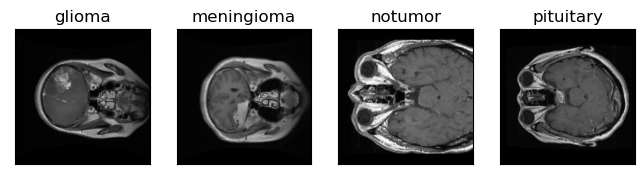

In [21]:
# Sample Images
dataset = ImageFolder(train_data, transform = train_transform)

fig = plt.figure(figsize=(8,8))
for i in range(len(classes)):
    ax = fig.add_subplot(1, 4, 1 + i, xticks=[], yticks=[])
    ax.set_title(classes[i])
    img = next(img for img, label in dataset if label == i)
    plt.imshow(img.T)
plt.show()

In [22]:
# Calculating the mean and std for normalizing inputs.
train_transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

dataset = ImageFolder(train_data, transform = train_transform)
testset = ImageFolder(test_data, transform = train_transform)
data = torch.stack([x for x, _ in dataset], dim=3)
labels = torch.Tensor([y for _, y in dataset])

print(data.shape)
print(data.view(3,-1).mean(dim=1))
print(data.view(3,-1).std(dim=1))

torch.Size([3, 128, 128, 5712])
tensor([0.1855, 0.1855, 0.1855])
tensor([0.1957, 0.1957, 0.1957])


In [23]:
# Converts into dataset to be processed.
train_transform = transforms.Compose([transforms.Resize((128,128)), 
                                      transforms.ToTensor(), 
                                      transforms.Grayscale(3),                #sync with Vishakha
                                      transforms.Normalize((0.1855, 0.1855, 0.1855),(0.1957, 0.1957, 0.1957))])
dataset = ImageFolder(train_data, transform = train_transform)
testset = ImageFolder(test_data, transform = train_transform)

In [24]:
# Seperates into batches for faster image processing.
batch_size = 32

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle = False)

In [25]:
# Setting up the model with VGG16 Architecture
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),  # Batches normalization for inputs.
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4*4*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 4))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [26]:
# Training model.
start_time = time.time()
torch.cuda.empty_cache()  # Empty unused caches in GPU

model = VGG16()
model = model.to(device)  # Points to the GPU

learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

epochs_count = []
loss_count = []
train_accuracy = []
val_accuracy = []

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        torch.cuda.empty_cache()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        torch.cuda.empty_cache()
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        
    epochs_count.append(epoch)
    loss_count.append(float(loss))
    if epoch % 1 == 0 or epoch == 79:
        print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    
    Train_correct = 0
    Train_total = 0
    Val_correct = 0
    Val_total = 0
    train_acc = 0
    val_acc = 0
    
    with torch.no_grad():
        # Determining training accuracy model to the training dataset.
        for imgs, labels in train_loader:
            torch.cuda.empty_cache()
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            torch.cuda.empty_cache()
            _, predicted = torch.max(outputs, dim=1)
            Train_total += labels.shape[0]
            Train_correct += int((predicted == labels).sum())
            del imgs, labels, outputs
            torch.cuda.empty_cache()
        
        # Determining validation accuracy model to the validation dataset.
        for imgs, labels in test_loader:
            torch.cuda.empty_cache()
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            torch.cuda.empty_cache()
            _, predicted = torch.max(outputs, dim=1)
            Val_total += labels.shape[0]
            Val_correct += int((predicted == labels).sum())
            del imgs, labels, outputs
            torch.cuda.empty_cache()
    if train_acc < (Train_correct / Train_total):
        train_acc = Train_correct / Train_total
    if val_acc < (Val_correct / Val_total):
        val_acc = Val_correct / Val_total
    train_accuracy.append(Train_correct / Train_total)
    val_accuracy.append(Val_correct / Val_total)
    if epoch % 1 == 0 or epoch == 79:
        print("Training Accuracy: %f" % (Train_correct / Train_total))
        print("Validation Accuracy: %f" % (Val_correct / Val_total))
        print("")
        
end_time = time.time()
elapsed = end_time - start_time
print("Training Time was:", elapsed, "seconds.")
torch.cuda.empty_cache()

Epoch: 0, Loss: 0.479170
Training Accuracy: 0.752801
Validation Accuracy: 0.397234

Epoch: 1, Loss: 0.181741
Training Accuracy: 0.893032
Validation Accuracy: 0.510679

Epoch: 2, Loss: 0.122019
Training Accuracy: 0.924020
Validation Accuracy: 0.583859

Epoch: 3, Loss: 0.231328
Training Accuracy: 0.935399
Validation Accuracy: 0.545693

Epoch: 4, Loss: 0.160647
Training Accuracy: 0.946429
Validation Accuracy: 0.568978

Epoch: 5, Loss: 0.201365
Training Accuracy: 0.940126
Validation Accuracy: 0.563025

Epoch: 6, Loss: 0.038489
Training Accuracy: 0.981268
Validation Accuracy: 0.679797

Epoch: 7, Loss: 0.232115
Training Accuracy: 0.951681
Validation Accuracy: 0.621849

Epoch: 8, Loss: 0.007296
Training Accuracy: 0.991246
Validation Accuracy: 0.722514

Epoch: 9, Loss: 0.014324
Training Accuracy: 0.992822
Validation Accuracy: 0.722339

Epoch: 10, Loss: 0.024482
Training Accuracy: 0.992997
Validation Accuracy: 0.725140

Epoch: 11, Loss: 0.124519
Training Accuracy: 0.981618
Validation Accuracy: 

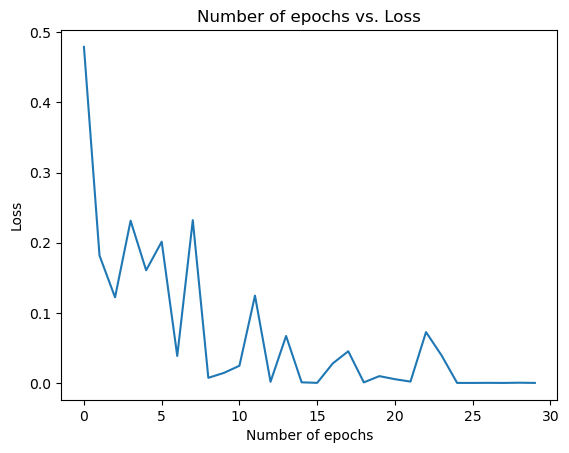

In [27]:
plt.figure(1)
plt.plot(epochs_count, loss_count)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Number of epochs vs. Loss")
plt.show()

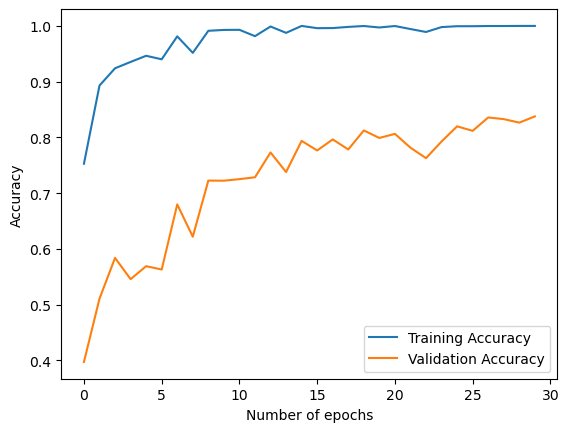

In [28]:
plt.figure(2)
plt.plot(epochs_count, train_accuracy, label = "Training Accuracy")
plt.plot(epochs_count, val_accuracy, label = "Validation Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

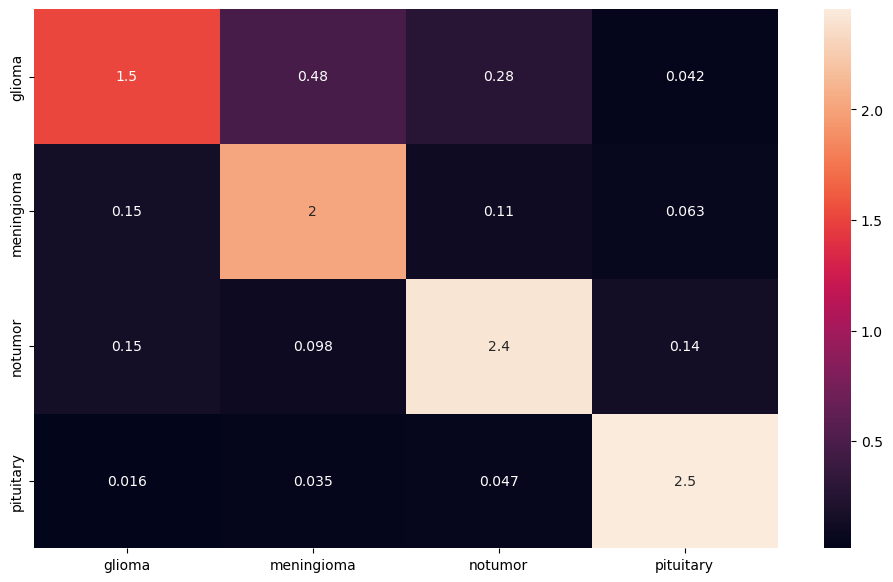

In [29]:
# Creating classification report and confusion matrix.
y_pred = []
y_true = []

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = model(imgs)
    
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)
    
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [30]:
# Final classification report. 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.66      0.73      1321
           1       0.77      0.86      0.81      1339
           2       0.85      0.86      0.85      1595
           3       0.91      0.96      0.94      1457

    accuracy                           0.84      5712
   macro avg       0.84      0.84      0.83      5712
weighted avg       0.84      0.84      0.84      5712

